In [2]:
import wav_handler as wh
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np
import dirtools as dt
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator
import os
import matplotlib
from scipy.optimize import curve_fit

from scipy.signal import argrelextrema, welch
from numpy.fft import fft, ifft
import scipy.stats
import amplifier_model as am
fs = 44100
input_files = dt.get_files('../data_soundcard/johnson_noise_massive/', fullpath=True)
fnames = dt.get_files('../data_soundcard/johnson_noise_massive/')

convertfactor = 106.373 / 1000 # +/- 2.126  / 1000 volts

def to_volts(amp):
    return convertfactor * amp


def get_resistance(name):
    num = ""
    for char in name:
        if char == "K":
            break
        num += char
    return float(num)

def cross_correlate(s1, s2):
    return signal.csd(s1, s2, fs=fs, nperseg=512) # s1 # np.mean([s1, s2], axis=0)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

11.888Kohm.wav 0.0033139428
49.138Kohm.wav 0.006781471
26.850Kohm.wav 0.004973654
39.3177Kohm.wav 0.0060549136
0.0046Kohm.wav 0.00083489297
298Kohm.wav 0.017534778
21.8157Kohm.wav 0.0044885073
0.009092Kohm.wav 0.0008365256
3.9Kohm.wav 0.0020169087
2.421Kohm.wav 0.0016592735
14.9Kohm.wav 0.0037262659
5.779Kohm.wav 0.0025495328
18.057Kohms.wav 0.004070581
30Kohm.wav 0.0052325753
35.9435Kohm.wav 0.0057903836
32.993Kohms.wav 0.0055296076
46.037Kohm.wav 0.006575748
0.0520Kohm.wav 0.00086011225
0.564Kohm.wav 0.0010862311
0.018Kohm.wav 0.0008426807
42.533Kohm.wav 0.006310773
0.201Kohm.wav 0.00093153596
0.988Kohm.wav 0.0012426593


Text(0, 0.5, 'A M P L I T U D E   ( $ V ^ 2 $ )')

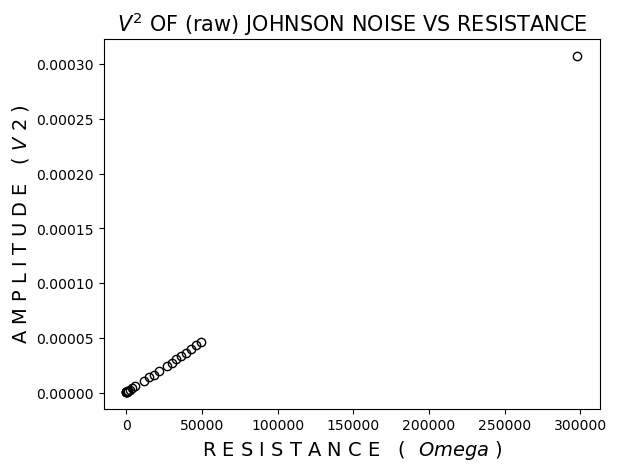

In [4]:
rmses = []

for file, name in zip(input_files, fnames):
    t, d = wh.importWAV(file)
    rms = np.mean([np.sqrt(np.mean(to_volts(d["right"])**2)), np.sqrt(np.mean(to_volts(d["left"])**2))])
    print(name, rms)
    rmses.append([get_resistance(name) * 1000, rms])

rmses = np.array(rmses)
fig, ax = plt.subplots()
ax.set_title(''.join('$V^{2}$ OF (raw) JOHNSON NOISE VS RESISTANCE'),
             fontsize=15)

ax.scatter(rmses[:,0], rmses[:,1]**2, color=[0,0,0,0], edgecolors='k')
ax.set_xlabel(" ".join("RESISTANCE ($\Omega$)"),
              fontsize=14)
ax.set_ylabel(" ".join("AMPLITUDE ($V^2$)"),
              fontsize=14)
# fig.savefig('resistances.svg', format='svg', dpi=1200)

In [3]:
def lin(x, m, b):
    return m * x + b

params, ncov = curve_fit(lin, rmses[:,0], rmses[:,1]**2)

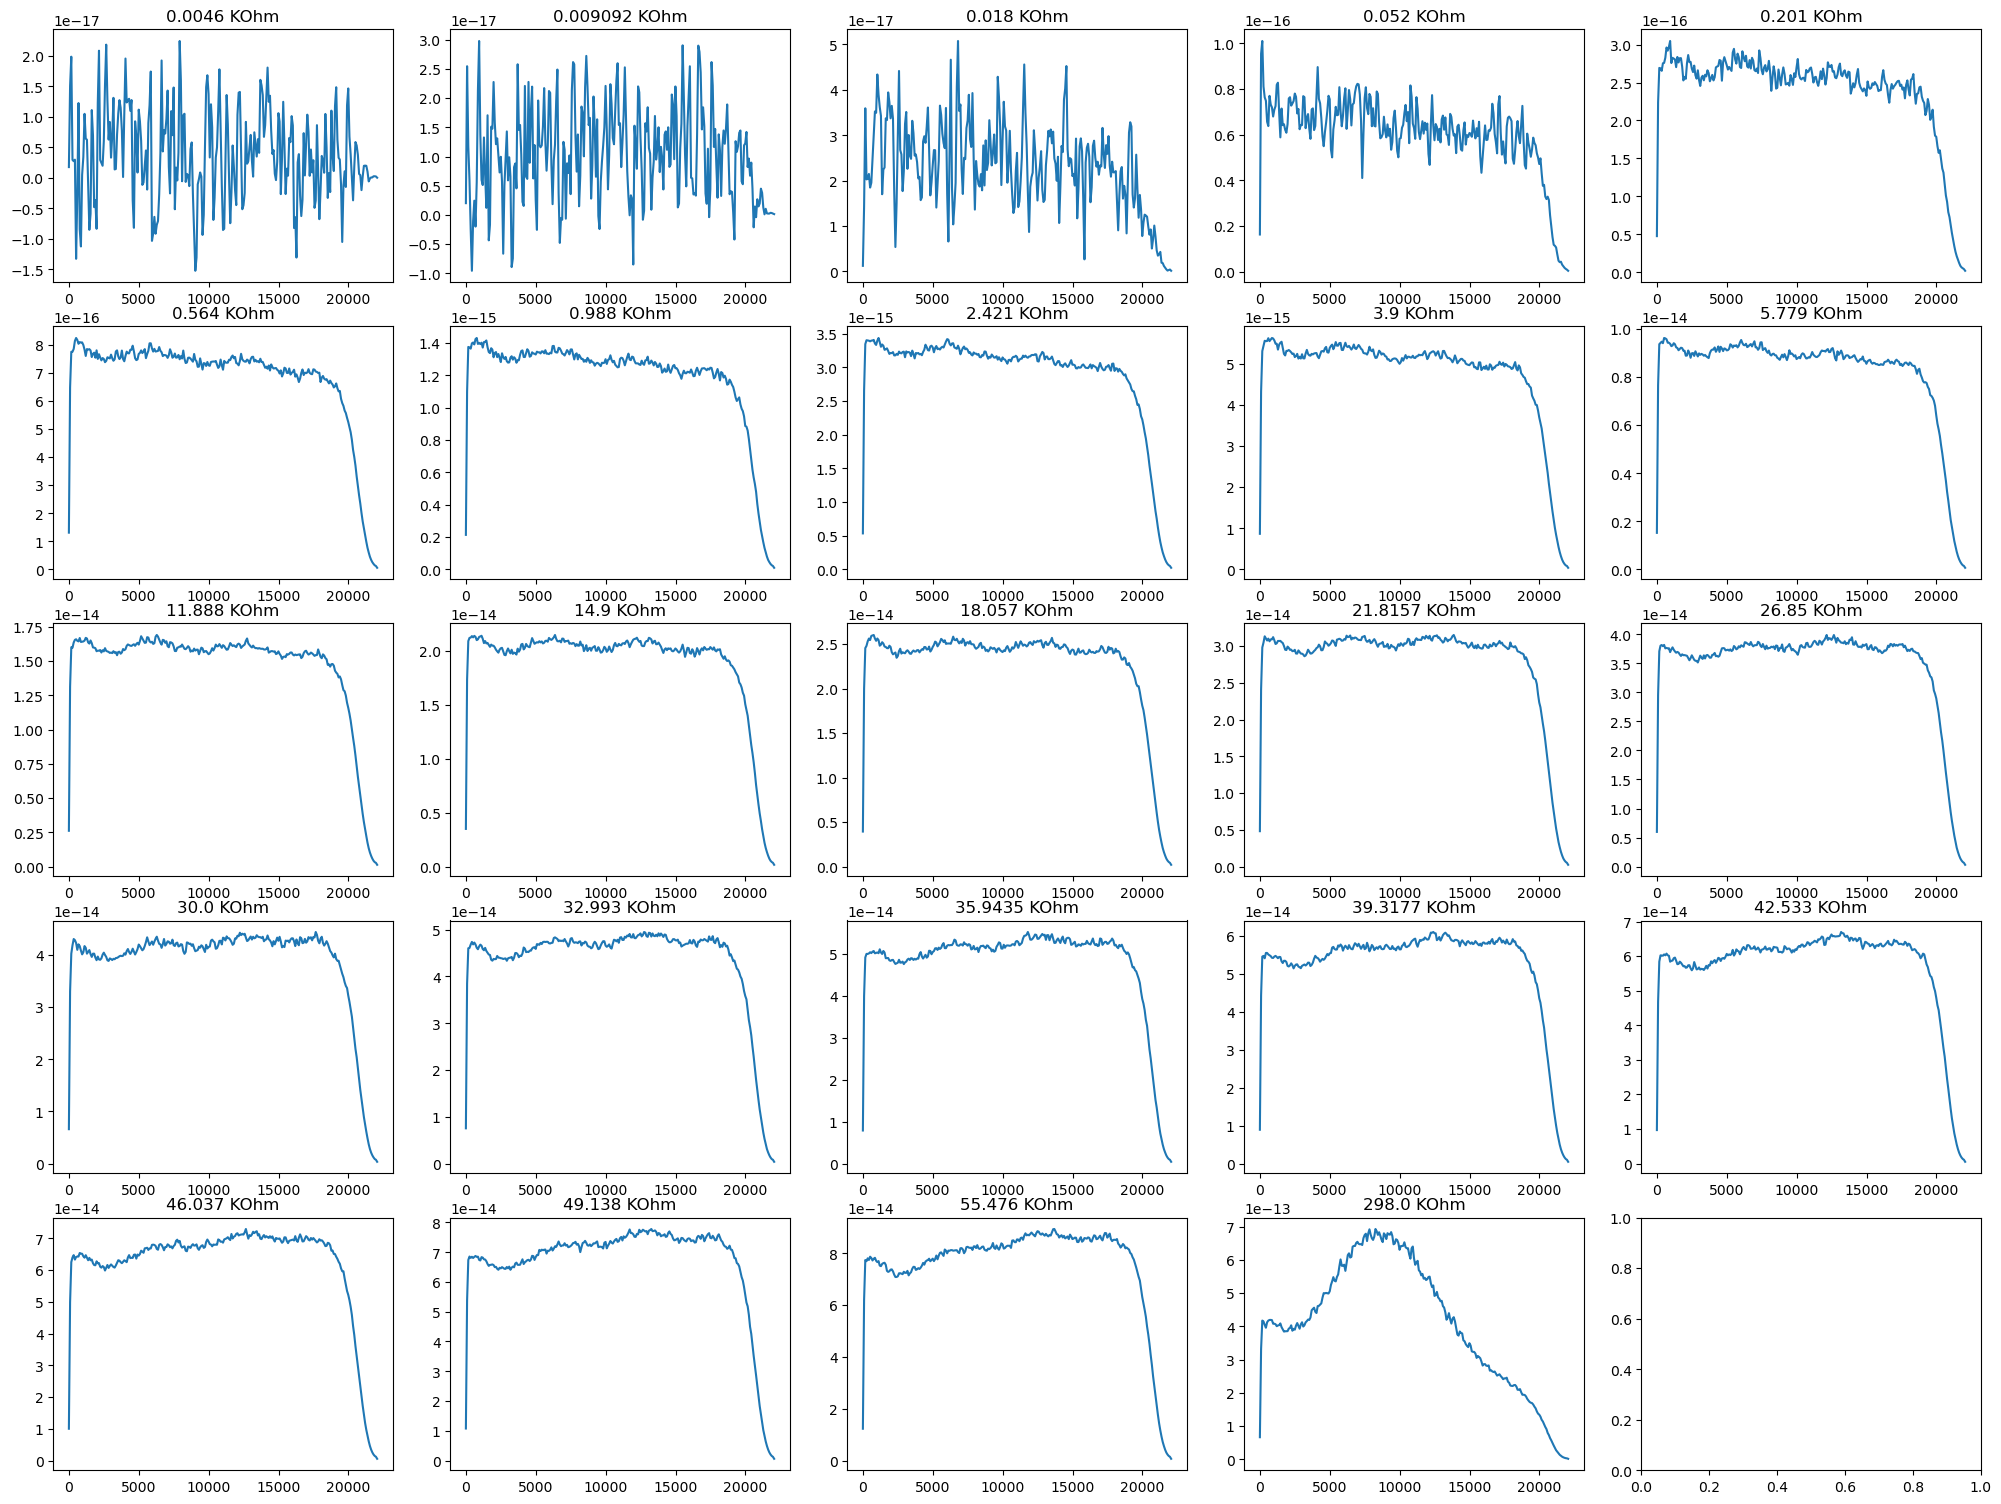

'\nf, Pxx_den = signal.welch(v, fs, nperseg=512)\nprint(scipy.stats.mode(np.diff(f)).mode)\ngain_model_squared = am.gain50(f, *am.measured_params)**2\npoly_gain_squared = am.polymod(f)**2\n'

In [9]:
# sort files based on resistances
input_files = dt.get_files('../data_soundcard/johnson_noise_massive/', fullpath=True)
fnames = dt.get_files('../data_soundcard/johnson_noise_massive/')

rez = [get_resistance(os.path.basename(x)) for x in input_files]
sorted_files = [x for _, x in sorted(zip(rez, input_files))]

fig, ax = plt.subplots(5, 5, figsize= (20, 15))
fig.tight_layout()

for F, a in zip(sorted_files, ax.reshape(-1)):
    # a.axis("off")
    t, d = wh.importWAV(F)
    f, Pxx_den = cross_correlate(d["left"], d["right"])
    a.plot(f, Pxx_den / am.polymod(f)**2)
    a.set_title("{} KOhm".format(get_resistance(os.path.basename(F))))
plt.show()
    

#fname = "298Kohm.wav"
# t, d = wh.importWAV("../data_soundcard/johnson_noise/" + fname)

# v = cross_correlate(d["left"], d["right"])

# no welch - raw
# f, Pxx_den = signal.periodogram(v, fs, 'boxcar', scaling='density')
'''
f, Pxx_den = signal.welch(v, fs, nperseg=512)
print(scipy.stats.mode(np.diff(f)).mode)
gain_model_squared = am.gain50(f, *am.measured_params)**2
poly_gain_squared = am.polymod(f)**2
'''


In [15]:
r_cutoff_start = 4
r_cutoff = 22
f_cutoff_start = 4 # 250 Hz cutoff for low-frequency misbehavior
f_cutoff_end = 215 # 18700 Hz cutoff for nyquist frequency filtering falloff
valid_input_files = sorted_files[r_cutoff_start:r_cutoff]

def get_amplitude(file, f_cutoff_start=4, f_cutoff_end=215):
    t, d = wh.importWAV(file)
    f, Pxx_den = cross_correlate(d["left"], d["right"])
    f = f[f_cutoff_start:f_cutoff_end]
    Pxx_den = Pxx_den[f_cutoff_start:f_cutoff_end]
    normalized = Pxx_den / am.polymod(f)**2
    # plt.plot(f, Pxx_den / am.polymod(f)**2, label="file")
    return normalized.mean(), normalized.std()


data = [get_amplitude(i) for i in valid_input_files]
ydelta = [i[1] for i in data]
y = [i[0] for i in data]
# plt.scatter(rez[r_cutoff_start:r_cutoff], np.abs(y))#, yerr=ydelta, lw=1)

In [20]:
def lin(x, m, b):
    return m * x + b
df = np.mean(np.diff(f))
params, ncov = curve_fit(lin, sorted(rez)[r_cutoff_start:r_cutoff], np.abs(y),  sigma=ydelta, absolute_sigma=False)

Assumed temperature: 21.85 C
kB = 1.3717 +/- 0.0190 * 10^-23 J s
Estimated temperature assuming kB invariant: 19.93 C


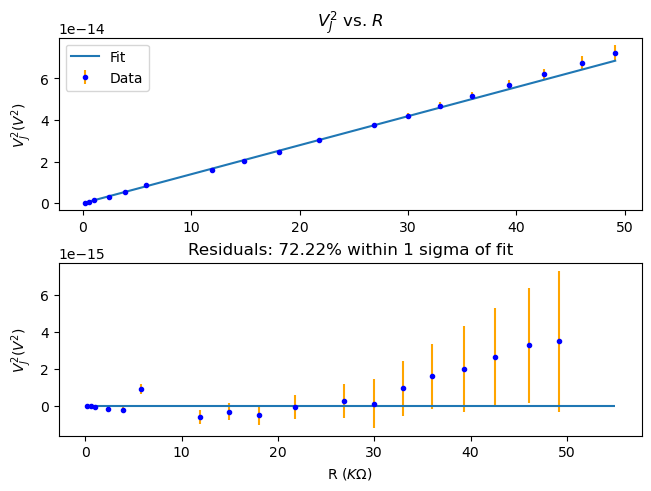

In [29]:
fig, ax = plt.subplots(2, 1, constrained_layout=True)
Rs = np.abs(sorted(rez)[r_cutoff_start:r_cutoff])
ax[0].errorbar(Rs, y, ydelta, ls='none', c="blue", marker=".", ecolor="orange", label="Data")
ax[0].plot(Rs, lin(np.array(Rs), params[0], params[1]), label="Fit")
ax[0].set_title("$V^2_J$ vs. $R$")
ax[1].set_xlabel("R $(K\Omega)$")
ax[1].set_ylabel("$V^2_J (V^2)$")
ax[0].set_ylabel("$V^2_J (V^2)$")
ax[0].legend()
kb_true = 1.380649E-23
temp = 295
kb = params[0] / (4 * temp * df * 1000)
dopt = np.sqrt(np.diag(ncov))
dkb = dopt[1]/ (4 * temp * df * 1000)



print(f"Assumed temperature: {temp - 273.15:.2f} C")
print(f"kB = {kb / 1E-23:.4f} +/- {dkb / 1E-23:.4f} * 10^-23 J s")
print(f"Estimated temperature assuming kB invariant: {params[0] / (4 * kb_true * df * 1000) - 273.15:.2f} C")
within = np.sum(np.abs(lin(Rs, params[0], params[1]) - y) < ydelta)
ax[1].set_title(f"Residuals: {100 * within / len(Rs):.2f}% within 1 sigma of fit")
ax[1].errorbar(Rs, np.abs(y) - lin(Rs, params[0], params[1]), ydelta, ls='none', c="blue", marker=".", ecolor="orange")
ax[1].hlines(0, 0, 55)
# print(scipy.stats.chisquare(np.abs(y), lin(np.array(sorted(rez)[r_cutoff_start:r_cutoff]))))